# SIFT

In [13]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [14]:
def extract_sift_features(image_path):
    """
    Extract SIFT features from an image.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        tuple: (keypoints, descriptors)
    """
    # Read image
    img = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    return keypoints, descriptors

In [15]:
def compute_similarity(desc1, desc2):
    """
    Compute similarity between two sets of descriptors using FLANN matcher.
    
    Args:
        desc1, desc2: SIFT descriptors of two images
        
    Returns:
        float: Similarity score between 0 and 1
    """
    if desc1 is None or desc2 is None:
        return 0.0
    
    # Initialize FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Find matches
    matches = flann.knnMatch(desc1, desc2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    # Calculate similarity score
    similarity_score = len(good_matches) / max(len(desc1), len(desc2))
    
    return similarity_score

In [16]:
def find_most_similar_sofa(query_image_path, database_dir):
    """
    Find the most similar sofa image in the database.
    
    Args:
        query_image_path (str): Path to the query image
        database_dir (str): Directory containing database images
        
    Returns:
        tuple: (most_similar_image_path, similarity_score)
    """
    # Extract features from query image
    query_kp, query_desc = extract_sift_features(query_image_path)
    
    best_score = -1
    best_match = None
    
    # Compare with all images in database
    for img_path in Path(database_dir).glob('*.jpg'):
        db_kp, db_desc = extract_sift_features(str(img_path))
        score = compute_similarity(query_desc, db_desc)
        
        if score > best_score:
            best_score = score
            best_match = img_path
    
    return str(best_match), best_score

In [17]:
def visualize_images(img1_path, img2_path, similarity_score=None):
    """
    Display two images side by side.
    
    Args:
        img1_path (str): Path to the first image
        img2_path (str): Path to the second image
        similarity_score (float, optional): Similarity score to display
    """
    # Read images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    
    # Convert from BGR to RGB
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    # Display images
    ax1.imshow(img1_rgb)
    ax1.set_title('Query Image')
    ax1.axis('off')
    
    ax2.imshow(img2_rgb)
    ax2.set_title('Most Similar Image')
    ax2.axis('off')
    
    if similarity_score is not None:
        plt.suptitle(f'Similarity Score: {similarity_score:.2f}', fontsize=16)
    
    plt.tight_layout()
    plt.show()

Most similar image: ../data/sofas/raw/image_20.jpg
Similarity score: 0.01


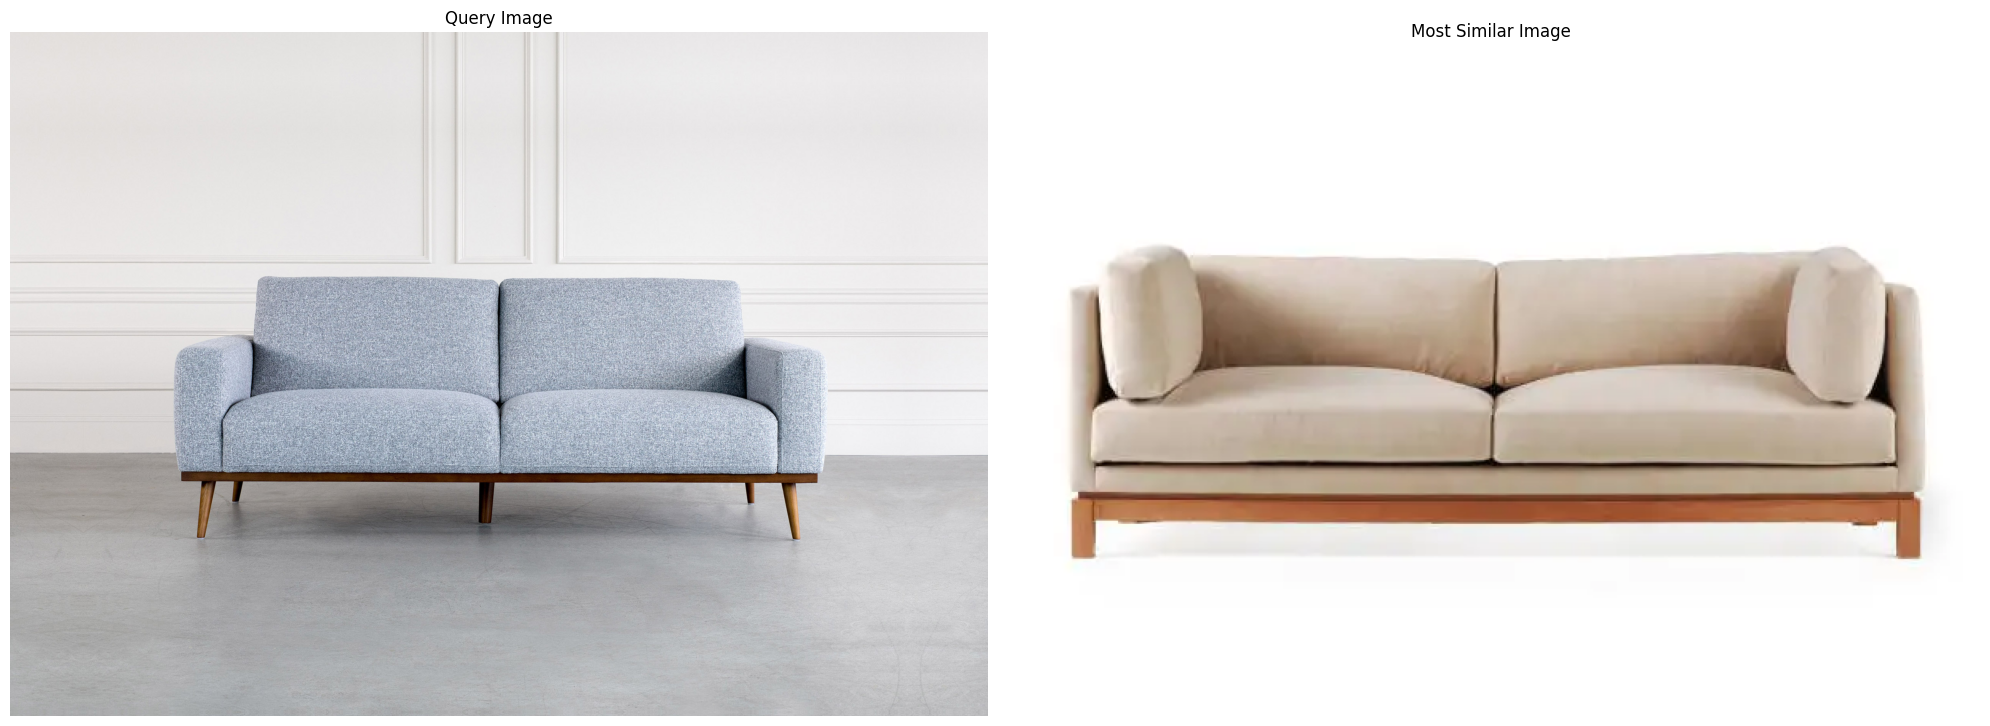

In [18]:
data_dir = "../data/sofas/raw"
query_image = "../data/sofas/test/image_1.jpg"

# Find most similar image
similar_image, similarity_score = find_most_similar_sofa(query_image, data_dir)
print(f"Most similar image: {similar_image}")
print(f"Similarity score: {similarity_score:.2f}")

# Visualize matches
visualize_images(query_image, similar_image)